In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ODE solver
from scipy.integrate import solve_ivp

# See below
import importlib

# This contains all the functions needed for simulation
import functions

# This helps reload the 'functions' module. By default, this is not done.
importlib.reload(functions) 

#from functions import RHS
#from functions import set_basal_parameter_values
#from functions import set_zero_initial_conditions
#from functions import set_equilibrium_initial_conditions
#from functions import get_hist
#from functions import set_basal_parameter_values_Michaels
#from functions import set_equilibrium_initial_conditions

<module 'functions' from 'C:\\Users\\bai_f\\Documents\\research\\TakedaInternship\\simulation\\functions.py'>

## Time evolution of Abeta species at basal parameter values

In [31]:
# Parameters and initial conditions
# Set basal parameter values
functions.set_basal_parameter_values()
# Turn off binding/unbinding, transportation, monomer production in ISF
# ... and antibody entrance
functions.set_basal_parameter_values_Michaels(basal_concentration=1e-9)
# Turn on monomer production in ISF
functions.parameters['k_ISF_AbM_syn'] = 7
# No antibody entrance (this is not necessary here, since the above two functions already did this)
functions.parameters['k_ISF_mAb_syn'] = 0
# Set clearance rate, only estimated
functions.parameters['k_ISF_AbM_clear'] = 0.1
functions.parameters['k_ISF_AbF_clear'] = 0.001


# Set all species to be zero, return y0 as the initial condition for ODE solver
y0 = functions.set_zero_initial_conditions()

# Time constants (in hours)
t_start = 0
t_end = 1 * functions.parameters['year_to_week'] * functions.parameters['week_to_hour']
t_span = [t_start, t_end]
t_eval = np.linspace(t_start, t_end, 100+1)

# Solve ODEs
sol = solve_ivp(functions.RHS, t_span, y0, 
                method='LSODA', t_eval = t_eval, rtol=1e-3, max_step=1e2)

# Get time histories of all species
# functions.get_hist(sol)

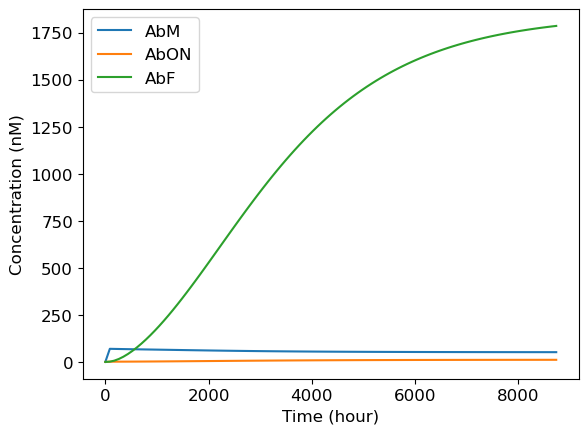

In [32]:
# Visualization
fig = plt.figure()
ax = fig.add_subplot(111)
fontsize = 12

t_hist = sol.t
ISF_AbM_hist = sol.y[functions.indices_species['ISF_AbM']]
ISF_AbF_hist = sol.y[functions.indices_species['ISF_AbF']]
ISF_AbON_hist = sol.y[functions.indices_species['ISF_AbON']]

ax.plot(t_hist, ISF_AbM_hist, label='ISF AbM')
ax.plot(t_hist, ISF_AbON_hist, label='ISF AbON')
ax.plot(t_hist, ISF_AbF_hist, label='ISF AbF')


ax.legend(fontsize=fontsize)

ax.set_xlabel('Time (hour)', fontsize=fontsize)
ax.set_ylabel('Concentration (nM)', fontsize=fontsize)

xmin_label = t_start
xmax_label = t_end
xmid_label = int((xmin_label + xmax_label)/2)

xmin = t_start
xmax = t_end
xmid = (xmin + xmax)/2


#ax.set_xticks((xmin, xmid, xmax))
#ax.set_xticklabels((xmin_label, xmid_label, xmax_label))

#ax.set_yticks((0, AbM_init/2, AbM_init))
#ax.set_yticklabels((0, AbM_init/2, AbM_init))

# Change tick label sizes
tick_label_size = fontsize
ax.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_label_size)

In [33]:
# Save figure
filename = "./figs/ISF_Ab_basal_levels.jpg"
fig.savefig(filename, dpi=600, bbox_inches="tight")

## Varying monomer production rate

In [34]:
base_value = functions.parameters['k_ISF_AbM_syn']

x_fold_min = 0
x_fold_max = 2
x_fold_mid = int((x_fold_min+x_fold_max)/2)

xmin = x_fold_min * base_value
xmax = x_fold_max * base_value
xmid = (xmin + xmax)/2

par_range = np.linspace(xmin, xmax, 101)



# Time constants
t_start = 0
t_end = 200000

t_span = [t_start, t_end]
t_eval = np.linspace(t_start, t_end, 100+1)

# Initial conditions
y0 = functions.set_zero_initial_conditions()


ISF_AbF_infty_list = []
ISF_AbON_infty_list = []
ISF_mAb_infty_list = []


for functions.parameters['k_ISF_AbM_syn'] in par_range:
    sol = solve_ivp(functions.RHS, t_span, y0, 
                    method='LSODA', t_eval = t_eval, rtol=1e-3, max_step=1e2)
    
    ISF_AbF_infty_list.append(sol.y[functions.indices_species['ISF_AbF'], -1] 
                             + sol.y[functions.indices_species['ISF_AbF1'], -1]
                             + sol.y[functions.indices_species['ISF_AbF2'], -1])                             
    ISF_AbON_infty_list.append(sol.y[functions.indices_species['ISF_AbON'], -1])
    ISF_mAb_infty_list.append(sol.y[functions.indices_species['ISF_mAb'], -1])
    

functions.parameters['k_ISF_AbM_syn'] = base_value

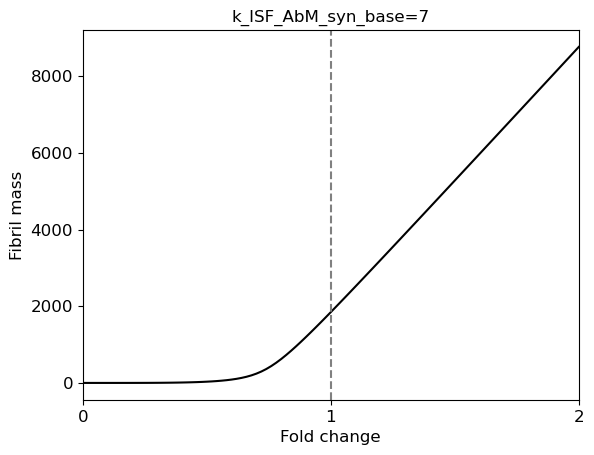

In [35]:
# Visualization of fibrils
fig = plt.figure()
ax = fig.add_subplot(111)
fontsize = 12

ax.plot(par_range, ISF_AbF_infty_list, color='black')
ax.axvline(x=base_value, color='grey', linestyle='--')

ax.set_title(f'k_ISF_AbM_syn_base={base_value}')

ax.set_xlabel('Fold change', fontsize=fontsize)
ax.set_ylabel('Fibril mass', fontsize=fontsize)

ax.set_xlim((xmin, xmax))
ax.set_xticks((xmin, xmid, xmax))
ax.set_xticklabels((x_fold_min, x_fold_mid, x_fold_max))

# Change tick label sizes
tick_label_size = fontsize
ax.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_label_size)



In [36]:
# Save figure
filename = "./figs/ISF_RateEffect_AbMProductionRate.jpg"
fig.savefig(filename, dpi=600, bbox_inches="tight")